In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import sklearn
from sklearn import linear_model
import seaborn as sns
%matplotlib inline

In [2]:
crime = pd.read_excel('new_york_crime_by_city_2013.xls')
df_crime = pd.DataFrame.from_dict(crime)
df_crime = df_crime.drop('Rape\n(revised\ndefinition)1', 1)
df_crime.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']

In [3]:
df_crime = df_crime[['Population', 'Murder', 'Robbery', 'Property_Crime']].dropna()

#print(df_crime.columns)

In [10]:
#creating a squared column for population
df_crime['population^2'] = (df_crime['Population']**2)

#creating a binary column for murder
df_crime['Murder_Feature'] = 0
df_crime.loc[
    (df_crime['Murder'] > 0),
    'Murder_Feature'
] = 1

#creating a binary column for robbery
df_crime['Robbery_Feature'] = 0
df_crime.loc[
    (df_crime.Robbery > 0),
    'Robbery_Feature'
] = 1

#creating a column to wrangle the population differences
df_crime['Major_City'] = 0
df_crime.loc[
    (df_crime.Population > 40000),
    'Major_City'
] = 1

In [11]:
df_crime.head()

,Population,Murder,Robbery,Property_Crime,population^2,Murder_Feature,Robbery_Feature,Major_City
0,1861.0,0.0,0.0,12.0,3.463321e+06,0,0,0
1,2577.0,0.0,0.0,24.0,6.640929e+06,0,0,0
2,2846.0,0.0,0.0,16.0,8.099716e+06,0,0,0
3,97956.0,8.0,227.0,4090.0,9.595378e+09,1,1,1
4,6388.0,0.0,4.0,223.0,4.080654e+07,0,1,0


In [7]:
df_crime.Population.describe()

count    3.480000e+02
mean     4.003763e+04
std      4.500374e+05
min      5.260000e+02
25%      3.003000e+03
50%      7.233500e+03
75%      1.842750e+04
max      8.396126e+06
Name: Population, dtype: float64

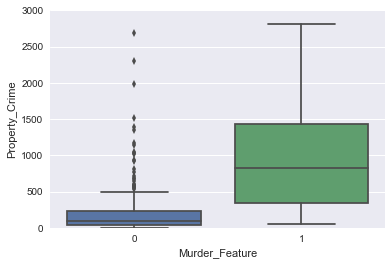

In [38]:
# boxplot showing the property crime distirbution based on the Murder Feature
plt.ylim(0, 3000)
sns.boxplot(y = 'Property_Crime', x = 'Murder_Feature', data = df_crime)

It looks like property crime is significantly more probable/common when a town's crimes include murder

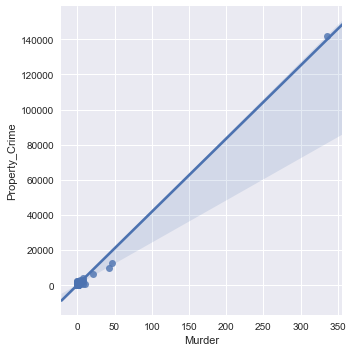

In [39]:
# plotting the murder rate against property crime rate
sns.lmplot('Murder', 'Property_Crime', data = df_crime)

Since the x and y axis are not to scale I'm not sure if interpreting the strong slope visually means anything. I wish there was a way to have the lmplot also output the equation it came up with.

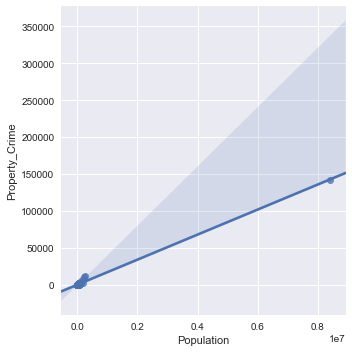

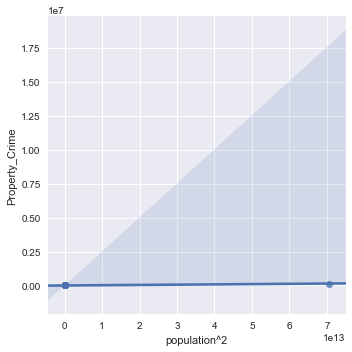

In [40]:
#Plotting both population and population squared against the property crime rate
sns.lmplot('Population', 'Property_Crime', data = df_crime)
sns.lmplot('population^2', 'Property_Crime', data = df_crime)
plt.show()

Logically speaking the bottom graph should have a shallower slope but there does not seem like a good way to plot this.

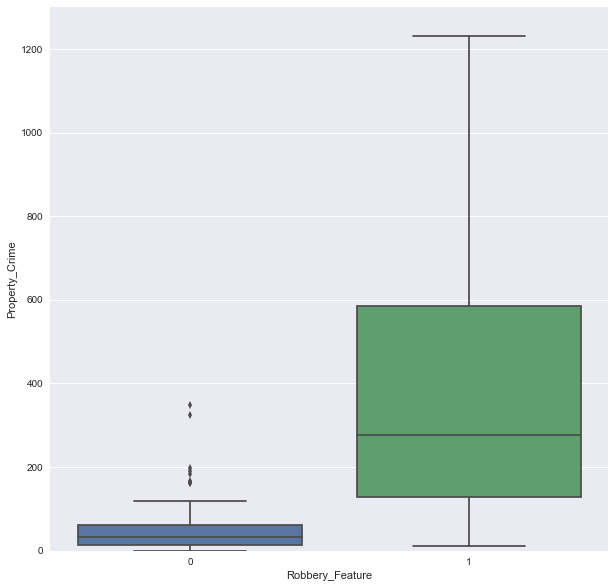

In [41]:
#Plotting distribution of property crime against the robbery feature
plt.figure(figsize = (10, 10))
plt.ylim(0,1300)
sns.boxplot(x = 'Robbery_Feature', y = 'Property_Crime', data = df_crime)

This plot would be a lot easier to see if I could turn it on its side but switching x and y do not have that effect.

## Data Issues

The main thing is going to be dealing with outliers and the main outlier for all of them is New York City. It skews everything. I created a dataframe just for that purpose and it worked better but it is still being skewed high on counts because of some of the major cities. A second dataframe might be worth it similar to the 'Major City' feature I created that only contains those types of cities. That would provide much cleaner analysis of crimes.

Truth be told I think it would be extremely difficult to model all of these cities into one model, but rather than writing multiple models perhaps you could have a tier system. Since NYC is out you will only need four tiers. A Tier 1 city could be the major cities below(population range 100k or above). A Tier 2 city would range from that 95th percentile mark up to the 100k mark in population and encompass the rest of the outliers. Tier 3 cities would be from the Median to the 95th percentile mark and Tier 4 would be every city below the Median. 

So instead of building separate models the Tier system would provide a number that the model could incorporate into the equation that would alter probabilities of Murder and Robbery features.

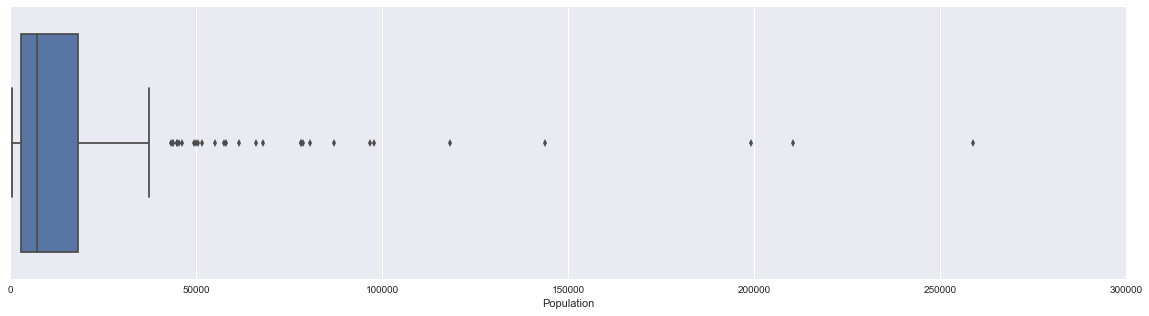

In [42]:
plt.figure(figsize = (20, 5))
plt.xlim(-5,300000)
sns.boxplot(x = 'Population', data = df_crime)

In [ ]:
plt.scatter(df_c)

## Regression model building

In [28]:
df_crime.columns #model is propertycrime = a + population + population^2 + Murder_feature + Robbery_feature

Index(['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Robbery',
       'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft',
       'Motor_Vehicle_Theft', 'Arson', 'population^2', 'Murder_Feature',
       'Robbery_Feature', 'Major_City'],
      dtype='object')

In [12]:
x = df_crime[['Population', 'population^2', 'Murder_Feature', 'Robbery_Feature', 'Major_City']]
y = df_crime['Property_Crime']

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(x,y))


Coefficients: 
 [  3.74134129e-02  -2.43432501e-09   7.35254352e+01  -1.06325917e+02
  -3.91488220e+02]
Intercept: 
 -122.567043799

R-squared: 
 0.99620639714


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [13]:
x = df_crime[['population^2', 'Murder_Feature', 'Robbery_Feature', 'Major_City']]
y = df_crime['Property_Crime']

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(x,y))

#x.describe()

Coefficients: 
 [  1.97700157e-09   4.32186017e+02   1.93346614e+02   1.94543191e+03]
Intercept: 
 45.4959437395

R-squared: 
 0.989587837549


In [14]:
x = df_crime[['Population', 'Murder_Feature', 'Robbery_Feature', 'Major_City']]
y = df_crime['Property_Crime']

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(x,y))

#x.describe()

Coefficients: 
 [  1.67971775e-02   2.68885173e+02   5.91185775e+01   8.89294741e+02]
Intercept: 
 -29.9416242434

R-squared: 
 0.994193809177


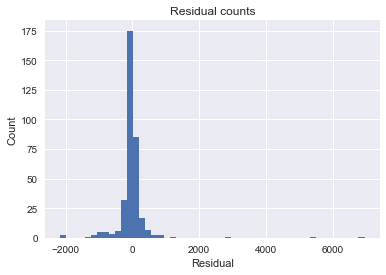

In [17]:
# Extract predicted values.
predicted = regr.predict(x).ravel()
actual = df_crime['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()